# Independent Feature EDA

Before performing any eda on the target (which will occur only after a train test split), I will look at the independent features held in the data set.  I do not want to look at the target, graduation rate, until after the split, so that I can prevent introducing bias into the model. 

First, I will look at the most current year data in the csv folder (2018-19).  

In [73]:
%load_ext autoreload
%autoreload 2

import os, sys
# Set absolute path to the root folder of the directory
full_path = os.getcwd()
home_folder = 'CPS_GradRate_Analysis'
root = full_path.split(home_folder)[0] + home_folder + '/'
sys.path.append(root)

# Cleaning functions are imported from the cleaning.py file in the src folder
from src.cleaning import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [74]:
# Create 2018-2019 SchoolYear class
path_to_pr_1819 = root + 'data/chicago_data_portal_csv_files/Chicago_Public_Schools_-_School_Progress_Reports_SY1819.csv'
path_to_sp_1819 = root + 'data/chicago_data_portal_csv_files/Chicago_Public_Schools_-_School_Profile_Information_SY1819.csv'

# Custom functions in src/cleaning.py

# sy_1819 will hold data about all of the schools to allow for eda on the entire student population
sy_1819 = import_and_merge_data(path_to_sp_1819, path_to_pr_1819)

# As shown below, the high school df will be cleaned to have a specific subset of records
sy_1819_hs = import_and_merge_data(path_to_sp_1819, path_to_pr_1819)
sy_1819_hs = convert_is_high_school_to_bool(sy_1819_hs)
sy_1819_hs = isolate_high_schools(sy_1819_hs)
sy_1819_hs.shape

(176, 276)

In [75]:
# These will be used to create new features that describe change in school populations
path_to_pr_1718 = root + '/data/chicago_data_portal_csv_files/Chicago_Public_Schools_-_School_Progress_Reports_SY1718.csv'
path_to_sp_1718 = root + '/data/chicago_data_portal_csv_files/Chicago_Public_Schools_-_School_Profile_Information_SY1718.csv'
sy_1718 = import_and_merge_data(path_to_sp_1718, path_to_pr_1718)

# As shown below, the high school df will be cleaned to have a specific subset of records
sy_1718_hs = import_and_merge_data(path_to_sp_1718, path_to_pr_1718)
sy_1718_hs = convert_is_high_school_to_bool(sy_1718_hs)
sy_1718_hs = isolate_high_schools(sy_1718_hs)



In [76]:
# These will be used to create new features that describe change in school populations
path_to_pr_1617 = root + '/data/chicago_data_portal_csv_files/Chicago_Public_Schools_-_School_Progress_Reports_SY1617.csv'
path_to_sp_1617 = root + '/data/chicago_data_portal_csv_files/Chicago_Public_Schools_-_School_Profile_Information_SY1617.csv'
sy_1617 = import_and_merge_data(path_to_sp_1617, path_to_pr_1617)

# As shown below, the high school df will be cleaned to have a specific subset of records
sy_1617_hs = import_and_merge_data(path_to_sp_1617, path_to_pr_1617)
sy_1617_hs = convert_is_high_school_to_bool(sy_1617_hs)
sy_1617_hs = isolate_high_schools(sy_1617_hs)


# School Counts

In 2018-2019, there are 651 total schools in CPS and there are 176 high schools.

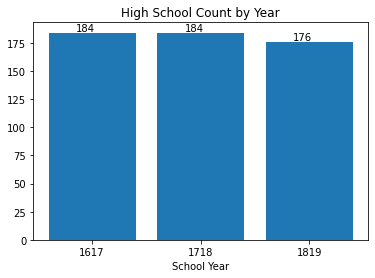

In [77]:
fig, ax = plt.subplots()
hs_counts = {'1617': len(sy_1617_hs.School_ID.unique()),
             '1718': len(sy_1718_hs.School_ID.unique()),
             '1819': len(sy_1819_hs.School_ID.unique())}

bars = ax.bar(list(hs_counts.keys()), list(hs_counts.values()))
ax.set_title('High School Count by Year')
ax.set_xlabel('School Year')

for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x()+ .25, yval + 1, yval)


## High School Counts by Network

CPS High Schools are organized into 4 Networks numbered 14 - 17.  There are also three 3 "other networks":
  - [ISP (Independent School Principals)](https://www.cps.edu/schools/networks/network-isp/)
  >> "Independent School Principals (ISP) is designed for the highest-performing principals within the district.ISP provides support to principals who can ensure continued strong performance with minimal oversight from the district, and who would benefit from additional independence to lead their schools." 
  - [Academy for Urban School Leadership (AUSL)](https://www.cps.edu/schools/networks/network-ausl/)
  >> "Founded in 2001 as the nation’s ﬁrst teacher residency program, Academy for Urban School Leadership (AUSL) grew by transforming underperforming schools in Chicago. The Academy for Urban School Leadership is a non-profit school management organization that leads one of the largest school networks in Chicago with 31 neighborhood Schools of Excellence."
  - [Charter, Contract, and Options Schools](https://www.cps.edu/schools/networks/network-charter-contract-options/)
  >> CPS charter and contract schools offer additional public elementary and high school choices for Chicago students. CPS Options schools are designed to be a unique learning model for students who are not engaged in a traditional high school and seek an alternative pathway to graduation that leads to college and career success.



The school count in the4 numbered school districts are evenly distributed from between 16 and 18 schools each. The ISP discrict also falls in that range. Charter and Options networks have a larger number of schools. Contract and AUSL have only a handful of schools each.     

<ipython-input-78-0b048e6cdaaa>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x, rotation=45);


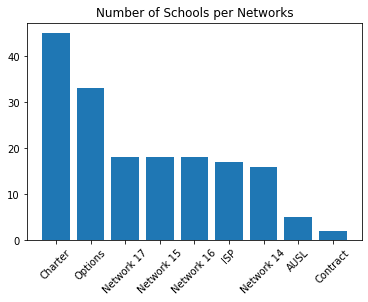

In [78]:
fig, ax = plt.subplots()

y = sy_1819_hs['Network'].value_counts().values
x = sy_1819_hs['Network'].value_counts().index

ax.bar(x,y)
ax.set_xticklabels(x, rotation=45);
ax.set_title('Number of Schools per Networks');

In [79]:
sy_1819_hs['Network'].value_counts()

Charter       45
Options       33
Network 17    18
Network 15    18
Network 16    18
ISP           17
Network 14    16
AUSL           5
Contract       2
Name: Network, dtype: int64

## Dropping Schools whose records in the 2018-19 year have no student count.

There are 2 schools in the data set that do not have student counts.  Englewood STEM HS didn't open until 2019, per their [website](https://englestem.enschool.org/apps/pages/index.jsp?uREC_ID=447546&type=d&pREC_ID=843929). YCCS is a Virtual High School, whose online records don't show student counts.  These are dropped in the current version of the project.

In [88]:
sy_1819_hs[sy_1819_hs['Student_Count_Total']==0]

,School_ID,Legacy_Unit_ID,Finance_ID,Short_Name_sp,Long_Name_sp,Primary_Category_sp,Is_High_School,Is_Middle_School,Is_Elementary_School,Is_Pre_School,Summary,Administrator_Title,Administrator,Secondary_Contact_Title,Secondary_Contact,Address_sp,City_sp,State_sp,Zip_sp,Phone_sp,Fax_sp,CPS_School_Profile_sp,Website_sp,Facebook,Twitter,Youtube,Pinterest,Attendance_Boundaries,Grades_Offered_All,Grades_Offered,Student_Count_Total,Student_Count_Low_Income,Student_Count_Special_Ed,Student_Count_English_Learners,Student_Count_Black,Student_Count_Hispanic,Student_Count_White,Student_Count_Asian,Student_Count_Native_American,Student_Count_Other_Ethnicity,Student_Count_Asian_Pacific_Islander,Student_Count_Multi,Student_Count_Hawaiian_Pacific_Islander,Student_Count_Ethnicity_Not_Available,Statistics_Description,Demographic_Description,Dress_Code,PreK_School_Day,Kindergarten_School_Day,School_Hours,Freshman_Start_End_Time,After_School_Hours,Earliest_Drop_Off_Time,Classroom_Languages,Bilingual_Services,Refugee_Services,Title_1_Eligible,PreSchool_Inclusive,Preschool_Instructional,Significantly_Modified,Hard_Of_Hearing,Visual_Impairments,Transportation_Bus,Transportation_El,Transportation_Metra,School_Latitude_sp,School_Longitude_sp,Average_ACT_School,Mean_ACT,College_Enrollment_Rate_School,College_Enrollment_Rate_Mean,Graduation_Rate_School,Graduation_Rate_Mean,Overall_Rating,Rating_Status,Rating_Statement,Classification_Description,School_Year,Third_Contact_Title,Third_Contact_Name,Fourth_Contact_Title,Fourth_Contact_Name,Fifth_Contact_Title,Fifth_Contact_Name,Sixth_Contact_Title,Sixth_Contact_Name,Seventh_Contact_Title,Seventh_Contact_Name,Network,Is_GoCPS_Participant,Is_GoCPS_PreK,Is_GoCPS_Elementary,Is_GoCPS_High_School,Open_For_Enrollment_Date,Closed_For_Enrollment_Date,Short_Name_pr,Long_Name_pr,School_Type,Primary_Category_pr,Address_pr,City_pr,State_pr,Zip_pr,Phone_pr,Fax_pr,CPS_School_Profile_pr,Website_pr,Progress_Report_Year,Blue_Ribbon_Award_Year,Excelerate_Award_Gold_Year,Spot_Light_Award_Year,Improvement_Award_Year,Excellence_Award_Year,Student_Growth_Rating,Student_Growth_Description,Growth_Reading_Grades_Tested_Pct_ES,Growth_Reading_Grades_Tested_Label_ES,Growth_Math_Grades_Tested_Pct_ES,Growth_Math_Grades_Tested_Label_ES,Student_Attainment_Rating,Student_Attainment_Description,Attainment_Reading_Pct_ES,Attainment_Reading_Lbl_ES,Attainment_Math_Pct_ES,Attainment_Math_Lbl_ES,Culture_Climate_Rating,Culture_Climate_Description,School_Survey_Student_Response_Rate_Pct,School_Survey_Student_Response_Rate_Avg_Pct,School_Survey_Teacher_Response_Rate_Pct,School_Survey_Teacher_Response_Rate_Avg_Pct,School_Survey_Parent_Response_Rate_Pct,School_Survey_Parent_Response_Rate_Avg_Pct,Healthy_School_Certification,Healthy_School_Certification_Description,Creative_School_Certification,Creative_School_Certification_Description,NWEA_Reading_Growth_Grade_3_Pct,NWEA_Reading_Growth_Grade_3_Lbl,NWEA_Reading_Growth_Grade_4_Pct,NWEA_Reading_Growth_Grade_4_Lbl,NWEA_Reading_Growth_Grade_5_Pct,NWEA_Reading_Growth_Grade_5_Lbl,NWEA_Reading_Growth_Grade_6_Pct,NWEA_Reading_Growth_Grade_6_Lbl,NWEA_Reading_Growth_Grade_7_Pct,NWEA_Reading_Growth_Grade_7_Lbl,NWEA_Reading_Growth_Grade_8_Pct,NWEA_Reading_Growth_Grade_8_Lbl,NWEA_Math_Growth_Grade_3_Pct,NWEA_Math_Growth_Grade_3_Lbl,NWEA_Math_Growth_Grade_4_Pct,NWEA_Math_Growth_Grade_4_Lbl,NWEA_Math_Growth_Grade_5_Pct,NWEA_Math_Growth_Grade_5_Lbl,NWEA_Math_Growth_Grade_6_Pct,NWEA_Math_Growth_Grade_6_Lbl,NWEA_Math_Growth_Grade_7_Pct,NWEA_Math_Growth_Grade_7_Lbl,NWEA_Math_Growth_Grade_8_Pct,NWEA_Math_Growth_Grade_8_Lbl,NWEA_Reading_Attainment_Grade_2_Pct,NWEA_Reading_Attainment_Grade_2_Lbl,NWEA_Reading_Attainment_Grade_3_Pct,NWEA_Reading_Attainment_Grade_3_Lbl,NWEA_Reading_Attainment_Grade_4_Pct,NWEA_Reading_Attainment_Grade_4_Lbl,NWEA_Reading_Attainment_Grade_5_Pct,NWEA_Reading_Attainment_Grade_5_Lbl,NWEA_Reading_Attainment_Grade_6_Pct,NWEA_Reading_Attainment_Grade_6_Lbl,NWEA_Reading_Attainment_Grade_7_Pct,NWEA_Readi

In [89]:
sy_1819_hs = drop_no_students(sy_1819_hs)
len(sy_1819_hs.School_ID.unique())

0 Student Count
2 schools
15     ENGLEWOOD STEM HS
582       YCCS - VIRTUAL
Name: Short_Name_sp, dtype: object
All 0 Student Count Schools Dropped


174

In [90]:
# These same schools also have no student count in 1718
sy_1718_hs[sy_1718_hs['School_ID'].isin([610592, 400142])]['Student_Count_Total']

604    0
633    0
Name: Student_Count_Total, dtype: int64

Although there are a large number of Options schools, these schools serve a small population, as shown in the plots below.

Text(0, 0.5, 'Total # of Students')

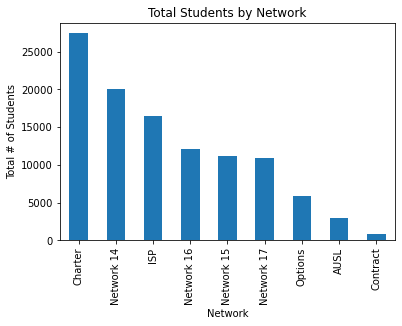

In [100]:
student_count_by_network = sy_1819_hs.groupby("Network").sum()['Student_Count_Total'].sort_values(ascending=False)

fig, ax = plt.subplots()

student_count_by_network.plot(kind='bar', ax = ax)
ax.set_title('Total Students by Network')
ax.set_ylabel('Total # of Students')

Network 14 serves the most students per school. 

Text(0, 0.5, 'Mean # of Students per Network')

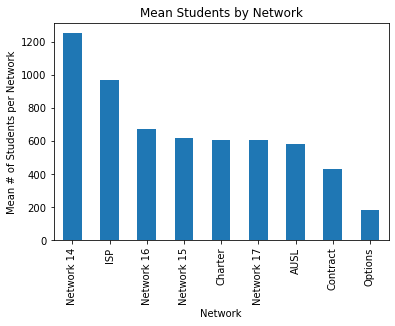

In [101]:
student_count_by_network = sy_1819_hs.groupby("Network").mean()['Student_Count_Total'].sort_values(ascending=False)

fig, ax = plt.subplots()

student_count_by_network.plot(kind='bar', ax = ax)
ax.set_title('Mean Students by Network')
ax.set_ylabel('Mean # of Students per Network')

In [66]:
sy_1819_hs[sy_1819_hs['Graduation_Rate_School']==0]

,School_ID,Legacy_Unit_ID,Finance_ID,Short_Name_sp,Long_Name_sp,Primary_Category_sp,Is_High_School,Is_Middle_School,Is_Elementary_School,Is_Pre_School,Summary,Administrator_Title,Administrator,Secondary_Contact_Title,Secondary_Contact,Address_sp,City_sp,State_sp,Zip_sp,Phone_sp,Fax_sp,CPS_School_Profile_sp,Website_sp,Facebook,Twitter,Youtube,Pinterest,Attendance_Boundaries,Grades_Offered_All,Grades_Offered,Student_Count_Total,Student_Count_Low_Income,Student_Count_Special_Ed,Student_Count_English_Learners,Student_Count_Black,Student_Count_Hispanic,Student_Count_White,Student_Count_Asian,Student_Count_Native_American,Student_Count_Other_Ethnicity,Student_Count_Asian_Pacific_Islander,Student_Count_Multi,Student_Count_Hawaiian_Pacific_Islander,Student_Count_Ethnicity_Not_Available,Statistics_Description,Demographic_Description,Dress_Code,PreK_School_Day,Kindergarten_School_Day,School_Hours,Freshman_Start_End_Time,After_School_Hours,Earliest_Drop_Off_Time,Classroom_Languages,Bilingual_Services,Refugee_Services,Title_1_Eligible,PreSchool_Inclusive,Preschool_Instructional,Significantly_Modified,Hard_Of_Hearing,Visual_Impairments,Transportation_Bus,Transportation_El,Transportation_Metra,School_Latitude_sp,School_Longitude_sp,Average_ACT_School,Mean_ACT,College_Enrollment_Rate_School,College_Enrollment_Rate_Mean,Graduation_Rate_School,Graduation_Rate_Mean,Overall_Rating,Rating_Status,Rating_Statement,Classification_Description,School_Year,Third_Contact_Title,Third_Contact_Name,Fourth_Contact_Title,Fourth_Contact_Name,Fifth_Contact_Title,Fifth_Contact_Name,Sixth_Contact_Title,Sixth_Contact_Name,Seventh_Contact_Title,Seventh_Contact_Name,Network,Is_GoCPS_Participant,Is_GoCPS_PreK,Is_GoCPS_Elementary,Is_GoCPS_High_School,Open_For_Enrollment_Date,Closed_For_Enrollment_Date,Short_Name_pr,Long_Name_pr,School_Type,Primary_Category_pr,Address_pr,City_pr,State_pr,Zip_pr,Phone_pr,Fax_pr,CPS_School_Profile_pr,Website_pr,Progress_Report_Year,Blue_Ribbon_Award_Year,Excelerate_Award_Gold_Year,Spot_Light_Award_Year,Improvement_Award_Year,Excellence_Award_Year,Student_Growth_Rating,Student_Growth_Description,Growth_Reading_Grades_Tested_Pct_ES,Growth_Reading_Grades_Tested_Label_ES,Growth_Math_Grades_Tested_Pct_ES,Growth_Math_Grades_Tested_Label_ES,Student_Attainment_Rating,Student_Attainment_Description,Attainment_Reading_Pct_ES,Attainment_Reading_Lbl_ES,Attainment_Math_Pct_ES,Attainment_Math_Lbl_ES,Culture_Climate_Rating,Culture_Climate_Description,School_Survey_Student_Response_Rate_Pct,School_Survey_Student_Response_Rate_Avg_Pct,School_Survey_Teacher_Response_Rate_Pct,School_Survey_Teacher_Response_Rate_Avg_Pct,School_Survey_Parent_Response_Rate_Pct,School_Survey_Parent_Response_Rate_Avg_Pct,Healthy_School_Certification,Healthy_School_Certification_Description,Creative_School_Certification,Creative_School_Certification_Description,NWEA_Reading_Growth_Grade_3_Pct,NWEA_Reading_Growth_Grade_3_Lbl,NWEA_Reading_Growth_Grade_4_Pct,NWEA_Reading_Growth_Grade_4_Lbl,NWEA_Reading_Growth_Grade_5_Pct,NWEA_Reading_Growth_Grade_5_Lbl,NWEA_Reading_Growth_Grade_6_Pct,NWEA_Reading_Growth_Grade_6_Lbl,NWEA_Reading_Growth_Grade_7_Pct,NWEA_Reading_Growth_Grade_7_Lbl,NWEA_Reading_Growth_Grade_8_Pct,NWEA_Reading_Growth_Grade_8_Lbl,NWEA_Math_Growth_Grade_3_Pct,NWEA_Math_Growth_Grade_3_Lbl,NWEA_Math_Growth_Grade_4_Pct,NWEA_Math_Growth_Grade_4_Lbl,NWEA_Math_Growth_Grade_5_Pct,NWEA_Math_Growth_Grade_5_Lbl,NWEA_Math_Growth_Grade_6_Pct,NWEA_Math_Growth_Grade_6_Lbl,NWEA_Math_Growth_Grade_7_Pct,NWEA_Math_Growth_Grade_7_Lbl,NWEA_Math_Growth_Grade_8_Pct,NWEA_Math_Growth_Grade_8_Lbl,NWEA_Reading_Attainment_Grade_2_Pct,NWEA_Reading_Attainment_Grade_2_Lbl,NWEA_Reading_Attainment_Grade_3_Pct,NWEA_Reading_Attainment_Grade_3_Lbl,NWEA_Reading_Attainment_Grade_4_Pct,NWEA_Reading_Attainment_Grade_4_Lbl,NWEA_Reading_Attainment_Grade_5_Pct,NWEA_Reading_Attainment_Grade_5_Lbl,NWEA_Reading_Attainment_Grade_6_Pct,NWEA_Reading_Attainment_Grade_6_Lbl,NWEA_Reading_Attainment_Grade_7_Pct,NWEA_Readi

Along with the schools with a graduation rate of 0, there are also 38 schools with N/A grad rates.  

In [30]:
sy_1819_hs[sy_1819_hs['Graduation_Rate_School'].isna()][['Short_Name_sp', 'Graduation_Rate_School', 'Network']].shape

(38, 3)

Of those 38, 25 are Option Schools.

In [31]:
sy_1819_hs[sy_1819_hs['Graduation_Rate_School'].isna()]['Network'].value_counts()

Options       25
Charter        7
ISP            5
Network 14     1
Name: Network, dtype: int64

That leaves only 7 Options Network schools with graduation rates. 

In [317]:
sy_1819_hs['Network'].value_counts()['Options']

32

THe drop_no_grad_rate function removes the 40 schools from the dataframe.

In [318]:
sy_1819_hs = drop_no_grad_rate(sy_1819_hs)


0 Graduation Rate
2 schools
261    PATHWAYS - AVONDALE HS
343     NORTHSIDE LEARNING HS
Name: Short_Name_sp, dtype: object
##########
NA Graduation Rates
38 schools
All 0/NA Graduation Rate Schools Dropped


In [319]:
len(sy_1819_hs.School_ID.unique())

134

Below is a list of school ids included in the 2017-18 school year, but not in the 2018-19 school year.

In [320]:
# schools_not_in_1819 = []
# for id_ in sy_1718.merged_df['School_ID']:
#      if id_ not in list(sy_1819_hs['School_ID']):
#             schools_not_in_1819.append(id_)
# schools_not_in_1819

# Important Features

As it is originally imported, the dataframe has 276 columns.  The `isolate_important_columns` function reduces this feature set to make exploratory data analysis easier.

In [321]:
sy_1819_hs.shape

(134, 276)

In [322]:
sy_1819_hs = isolate_important_columns(sy_1819_hs)
sy_1819_hs.shape

(134, 24)

## Student Count Total

Each school record includes the total number of students who attend a school.

There were 357,779 students enrolled in CPS in 2018-19. 

In [323]:
sy_1819['Student_Count_Total'].sum()

357779

The high school dataset after cleaning has 98,661 students in the 2018-19 school year.

In [324]:
sy_1819_hs['Student_Count_Total'].sum()

98661

In [325]:
sy_1819_hs['Student_Count_Total'].describe()

count     134.000000
mean      736.276119
std       657.342650
min        21.000000
25%       296.750000
50%       558.500000
75%       994.250000
max      4494.000000
Name: Student_Count_Total, dtype: float64

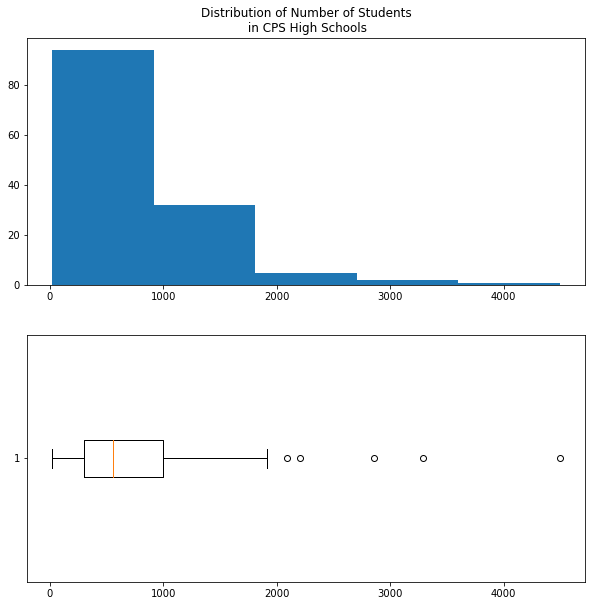

In [326]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(10,10))
ax1.hist(sy_1819_hs['Student_Count_Total'], bins=5)
ax2.boxplot(sy_1819_hs['Student_Count_Total'], vert=False)
ax1.set_title('Distribution of Number of Students\n in CPS High Schools');

The plots show a heavy right skew to the school total student counts.  There are 5 large high schools with student counts over 2000 students.

In [327]:
sy_1819_hs[sy_1819_hs['Student_Count_Total'] > 2000]\
        [['Short_Name_sp', 'Student_Count_Total']].sort_values('Student_Count_Total', ascending=False)


,Short_Name_sp,Student_Count_Total
625,LANE TECH HS,4494
643,TAFT HS,3294
636,CURIE HS,2859
202,YOUNG HS,2205
427,LINCOLN PARK HS,2094


The school with the largest student body is Lane Tech High School, with 4494 students.

In [328]:
sy_1819_hs[sy_1819_hs['Student_Count_Total'] == 
                  sy_1819_hs['Student_Count_Total'].max()][['Short_Name_sp', 'Student_Count_Total']]

,Short_Name_sp,Student_Count_Total
625,LANE TECH HS,4494


The median number of students is 404.

In [329]:
sy_1819_hs['Student_Count_Total'].median()

558.5

Text(0.5, 1.0, 'Student Count in Bins of 100\n: Largest bin is 200-300')

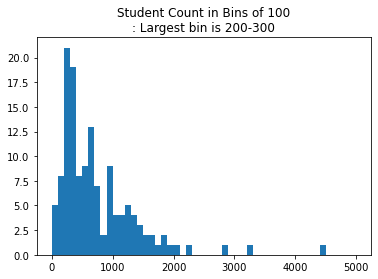

In [330]:
# Plot of counts in 2018-19 school year split into bins of 100 students
bins_100 = np.linspace(0,5000, 51)

fig, ax = plt.subplots()
ax.hist(sy_1819_hs['Student_Count_Total'], bins_100)
ax.set_title('Student Count in Bins of 100\n: Largest bin is 200-300')

## Interquartile Range: 219-853
The interquartile range for High School students count in the 2018-19 School Year is 219-853 students.

In [331]:
q75, q25 = np.percentile(sy_1819_hs['Student_Count_Total'], [75 ,25])
print(q25, q75)

296.75 994.25



## Schools in the lowest quartile of student counts 

In [332]:

low_quartile = sy_1819_hs[sy_1819_hs['Student_Count_Total'] < q25]

low_quartile.shape

(34, 24)

Text(0.5, 1.0, 'Options Networks have a High Proportion of Low Population Schools')

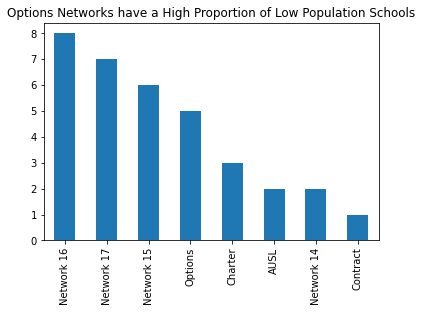

In [333]:
fig, ax = plt.subplots()
low_quartile['Network'].value_counts().plot(kind='bar', ax = ax)
ax.set_title('Options Networks have a High Proportion of Low Population Schools')

In [335]:
q90, q10 = np.percentile(sy_1819_hs['Student_Count_Total'], [90 ,10])
print(q90, q10)

1432.9 204.2


In [336]:
sy_1819_hs[sy_1819_hs['Student_Count_Total']<=q10].shape

(14, 24)

There are two high schools with 0 students on record. These will need to be dropped when modeling occurs.

In [119]:
sy_1819_hs[sy_1819_hs['Student_Count_Total']==0]

,School_ID,Legacy_Unit_ID,Finance_ID,Short_Name_sp,Long_Name_sp,Primary_Category_sp,Is_High_School,Is_Middle_School,Is_Elementary_School,Is_Pre_School,Summary,Administrator_Title,Administrator,Secondary_Contact_Title,Secondary_Contact,Address_sp,City_sp,State_sp,Zip_sp,Phone_sp,Fax_sp,CPS_School_Profile_sp,Website_sp,Facebook,Twitter,Youtube,Pinterest,Attendance_Boundaries,Grades_Offered_All,Grades_Offered,Student_Count_Total,Student_Count_Low_Income,Student_Count_Special_Ed,Student_Count_English_Learners,Student_Count_Black,Student_Count_Hispanic,Student_Count_White,Student_Count_Asian,Student_Count_Native_American,Student_Count_Other_Ethnicity,Student_Count_Asian_Pacific_Islander,Student_Count_Multi,Student_Count_Hawaiian_Pacific_Islander,Student_Count_Ethnicity_Not_Available,Statistics_Description,Demographic_Description,Dress_Code,PreK_School_Day,Kindergarten_School_Day,School_Hours,Freshman_Start_End_Time,After_School_Hours,Earliest_Drop_Off_Time,Classroom_Languages,Bilingual_Services,Refugee_Services,Title_1_Eligible,PreSchool_Inclusive,Preschool_Instructional,Significantly_Modified,Hard_Of_Hearing,Visual_Impairments,Transportation_Bus,Transportation_El,Transportation_Metra,School_Latitude_sp,School_Longitude_sp,Average_ACT_School,Mean_ACT,College_Enrollment_Rate_School,College_Enrollment_Rate_Mean,Graduation_Rate_School,Graduation_Rate_Mean,Overall_Rating,Rating_Status,Rating_Statement,Classification_Description,School_Year,Third_Contact_Title,Third_Contact_Name,Fourth_Contact_Title,Fourth_Contact_Name,Fifth_Contact_Title,Fifth_Contact_Name,Sixth_Contact_Title,Sixth_Contact_Name,Seventh_Contact_Title,Seventh_Contact_Name,Network,Is_GoCPS_Participant,Is_GoCPS_PreK,Is_GoCPS_Elementary,Is_GoCPS_High_School,Open_For_Enrollment_Date,Closed_For_Enrollment_Date,Short_Name_pr,Long_Name_pr,School_Type,Primary_Category_pr,Address_pr,City_pr,State_pr,Zip_pr,Phone_pr,Fax_pr,CPS_School_Profile_pr,Website_pr,Progress_Report_Year,Blue_Ribbon_Award_Year,Excelerate_Award_Gold_Year,Spot_Light_Award_Year,Improvement_Award_Year,Excellence_Award_Year,Student_Growth_Rating,Student_Growth_Description,Growth_Reading_Grades_Tested_Pct_ES,Growth_Reading_Grades_Tested_Label_ES,Growth_Math_Grades_Tested_Pct_ES,Growth_Math_Grades_Tested_Label_ES,Student_Attainment_Rating,Student_Attainment_Description,Attainment_Reading_Pct_ES,Attainment_Reading_Lbl_ES,Attainment_Math_Pct_ES,Attainment_Math_Lbl_ES,Culture_Climate_Rating,Culture_Climate_Description,School_Survey_Student_Response_Rate_Pct,School_Survey_Student_Response_Rate_Avg_Pct,School_Survey_Teacher_Response_Rate_Pct,School_Survey_Teacher_Response_Rate_Avg_Pct,School_Survey_Parent_Response_Rate_Pct,School_Survey_Parent_Response_Rate_Avg_Pct,Healthy_School_Certification,Healthy_School_Certification_Description,Creative_School_Certification,Creative_School_Certification_Description,NWEA_Reading_Growth_Grade_3_Pct,NWEA_Reading_Growth_Grade_3_Lbl,NWEA_Reading_Growth_Grade_4_Pct,NWEA_Reading_Growth_Grade_4_Lbl,NWEA_Reading_Growth_Grade_5_Pct,NWEA_Reading_Growth_Grade_5_Lbl,NWEA_Reading_Growth_Grade_6_Pct,NWEA_Reading_Growth_Grade_6_Lbl,NWEA_Reading_Growth_Grade_7_Pct,NWEA_Reading_Growth_Grade_7_Lbl,NWEA_Reading_Growth_Grade_8_Pct,NWEA_Reading_Growth_Grade_8_Lbl,NWEA_Math_Growth_Grade_3_Pct,NWEA_Math_Growth_Grade_3_Lbl,NWEA_Math_Growth_Grade_4_Pct,NWEA_Math_Growth_Grade_4_Lbl,NWEA_Math_Growth_Grade_5_Pct,NWEA_Math_Growth_Grade_5_Lbl,NWEA_Math_Growth_Grade_6_Pct,NWEA_Math_Growth_Grade_6_Lbl,NWEA_Math_Growth_Grade_7_Pct,NWEA_Math_Growth_Grade_7_Lbl,NWEA_Math_Growth_Grade_8_Pct,NWEA_Math_Growth_Grade_8_Lbl,NWEA_Reading_Attainment_Grade_2_Pct,NWEA_Reading_Attainment_Grade_2_Lbl,NWEA_Reading_Attainment_Grade_3_Pct,NWEA_Reading_Attainment_Grade_3_Lbl,NWEA_Reading_Attainment_Grade_4_Pct,NWEA_Reading_Attainment_Grade_4_Lbl,NWEA_Reading_Attainment_Grade_5_Pct,NWEA_Reading_Attainment_Grade_5_Lbl,NWEA_Reading_Attainment_Grade_6_Pct,NWEA_Reading_Attainment_Grade_6_Lbl,NWEA_Reading_Attainment_Grade_7_Pct,NWEA_Readi

There are 5 schools with less than 50 students.  As of yet, these will not be dropped, but may be dropped due to other filters.

In [120]:
sy_1819_hs[sy_1819_hs['Student_Count_Total']<50].shape

(5, 277)

**Modeling Note** All schools with no students will be dropped before modeling begins.

# Networks

# Low Income Students

### There is a strong positive correlation between Total number of students and Total numbere of low income students

Text(0.5, 1.0, 'Positive Correlation Between Total Students and Low Income Students')

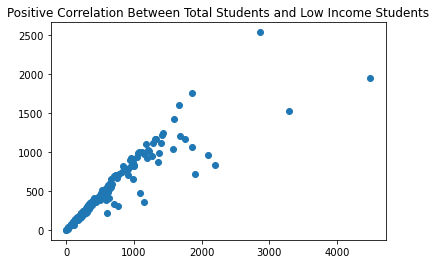

In [121]:
fig, ax = plt.subplots()

x = sy_1819_hs['Student_Count_Total']
y = sy_1819_hs['Student_Count_Low_Income']

ax.scatter(x, y )
ax.set_title("Positive Correlation Between Total Students and Low Income Students")

Text(0.5, 1.0, 'There are over 80 Schools\n with over 90% Low Income Students')

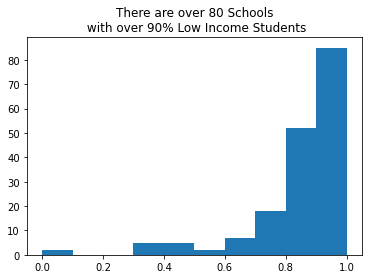

In [126]:
fig, ax = plt.subplots()

ax.hist(sy_1819_hs['perc_low_income'])
ax.set_title('There are over 80 Schools\n with over 90% Low Income Students')

Text(0.5, 1.0, 'Positive Correlation Between Total Students and Low Income Students')

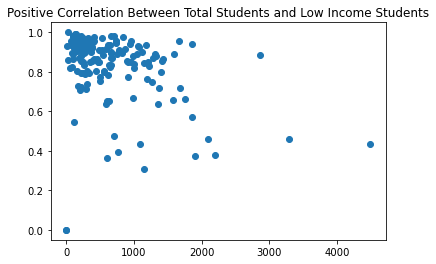

In [122]:
fig, ax = plt.subplots()

x = sy_1819_hs['Student_Count_Total']
y = sy_1819_hs['perc_low_income']

ax.scatter(x, y )
ax.set_title("Positive Correlation Between Total Students and Low Income Students")


In [ ]:
sy_1819_hs[sy_1819_hs['Student_Count_Total']<50]['Network']

5      Network 15
15            NaN
23     Network 16
95        Options
582       Options
Name: Network, dtype: object

In [ ]:
sy_1819_hs[sy_1819_hs['Student_Count_Total']<100]['Network']

5      Network 15
15            NaN
23     Network 16
60     Network 15
95        Options
175    Network 15
207           ISP
301       Options
352    Network 16
430       Options
582       Options
586       Options
649       Options
Name: Network, dtype: object

### Network NA's


In [ ]:
sy_1819_hs['Network'].isna().sum()

4

In [ ]:
sy_1819_hs[sy_1819_hs['Network'].isna()]

,School_ID,Legacy_Unit_ID,Finance_ID,Short_Name_sp,Long_Name_sp,Primary_Category_sp,Is_High_School,Is_Middle_School,Is_Elementary_School,Is_Pre_School,Summary,Administrator_Title,Administrator,Secondary_Contact_Title,Secondary_Contact,Address_sp,City_sp,State_sp,Zip_sp,Phone_sp,Fax_sp,CPS_School_Profile_sp,Website_sp,Facebook,Twitter,Youtube,Pinterest,Attendance_Boundaries,Grades_Offered_All,Grades_Offered,Student_Count_Total,Student_Count_Low_Income,Student_Count_Special_Ed,Student_Count_English_Learners,Student_Count_Black,Student_Count_Hispanic,Student_Count_White,Student_Count_Asian,Student_Count_Native_American,Student_Count_Other_Ethnicity,Student_Count_Asian_Pacific_Islander,Student_Count_Multi,Student_Count_Hawaiian_Pacific_Islander,Student_Count_Ethnicity_Not_Available,Statistics_Description,Demographic_Description,Dress_Code,PreK_School_Day,Kindergarten_School_Day,School_Hours,Freshman_Start_End_Time,After_School_Hours,Earliest_Drop_Off_Time,Classroom_Languages,Bilingual_Services,Refugee_Services,Title_1_Eligible,PreSchool_Inclusive,Preschool_Instructional,Significantly_Modified,Hard_Of_Hearing,Visual_Impairments,Transportation_Bus,Transportation_El,Transportation_Metra,School_Latitude_sp,School_Longitude_sp,Average_ACT_School,Mean_ACT,College_Enrollment_Rate_School,College_Enrollment_Rate_Mean,Graduation_Rate_School,Graduation_Rate_Mean,Overall_Rating,Rating_Status,Rating_Statement,Classification_Description,School_Year,Third_Contact_Title,Third_Contact_Name,Fourth_Contact_Title,Fourth_Contact_Name,Fifth_Contact_Title,Fifth_Contact_Name,Sixth_Contact_Title,Sixth_Contact_Name,Seventh_Contact_Title,Seventh_Contact_Name,Network,Is_GoCPS_Participant,Is_GoCPS_PreK,Is_GoCPS_Elementary,Is_GoCPS_High_School,Open_For_Enrollment_Date,Closed_For_Enrollment_Date,Short_Name_pr,Long_Name_pr,School_Type,Primary_Category_pr,Address_pr,City_pr,State_pr,Zip_pr,Phone_pr,Fax_pr,CPS_School_Profile_pr,Website_pr,Progress_Report_Year,Blue_Ribbon_Award_Year,Excelerate_Award_Gold_Year,Spot_Light_Award_Year,Improvement_Award_Year,Excellence_Award_Year,Student_Growth_Rating,Student_Growth_Description,Growth_Reading_Grades_Tested_Pct_ES,Growth_Reading_Grades_Tested_Label_ES,Growth_Math_Grades_Tested_Pct_ES,Growth_Math_Grades_Tested_Label_ES,Student_Attainment_Rating,Student_Attainment_Description,Attainment_Reading_Pct_ES,Attainment_Reading_Lbl_ES,Attainment_Math_Pct_ES,Attainment_Math_Lbl_ES,Culture_Climate_Rating,Culture_Climate_Description,School_Survey_Student_Response_Rate_Pct,School_Survey_Student_Response_Rate_Avg_Pct,School_Survey_Teacher_Response_Rate_Pct,School_Survey_Teacher_Response_Rate_Avg_Pct,School_Survey_Parent_Response_Rate_Pct,School_Survey_Parent_Response_Rate_Avg_Pct,Healthy_School_Certification,Healthy_School_Certification_Description,Creative_School_Certification,Creative_School_Certification_Description,NWEA_Reading_Growth_Grade_3_Pct,NWEA_Reading_Growth_Grade_3_Lbl,NWEA_Reading_Growth_Grade_4_Pct,NWEA_Reading_Growth_Grade_4_Lbl,NWEA_Reading_Growth_Grade_5_Pct,NWEA_Reading_Growth_Grade_5_Lbl,NWEA_Reading_Growth_Grade_6_Pct,NWEA_Reading_Growth_Grade_6_Lbl,NWEA_Reading_Growth_Grade_7_Pct,NWEA_Reading_Growth_Grade_7_Lbl,NWEA_Reading_Growth_Grade_8_Pct,NWEA_Reading_Growth_Grade_8_Lbl,NWEA_Math_Growth_Grade_3_Pct,NWEA_Math_Growth_Grade_3_Lbl,NWEA_Math_Growth_Grade_4_Pct,NWEA_Math_Growth_Grade_4_Lbl,NWEA_Math_Growth_Grade_5_Pct,NWEA_Math_Growth_Grade_5_Lbl,NWEA_Math_Growth_Grade_6_Pct,NWEA_Math_Growth_Grade_6_Lbl,NWEA_Math_Growth_Grade_7_Pct,NWEA_Math_Growth_Grade_7_Lbl,NWEA_Math_Growth_Grade_8_Pct,NWEA_Math_Growth_Grade_8_Lbl,NWEA_Reading_Attainment_Grade_2_Pct,NWEA_Reading_Attainment_Grade_2_Lbl,NWEA_Reading_Attainment_Grade_3_Pct,NWEA_Reading_Attainment_Grade_3_Lbl,NWEA_Reading_Attainment_Grade_4_Pct,NWEA_Reading_Attainment_Grade_4_Lbl,NWEA_Reading_Attainment_Grade_5_Pct,NWEA_Reading_Attainment_Grade_5_Lbl,NWEA_Reading_Attainment_Grade_6_Pct,NWEA_Reading_Attainment_Grade_6_Lbl,NWEA_Reading_Attainment_Grade_7_Pct,NWEA_Readi

## Number of students per network

In [ ]:
sy_1819_hs.groupby('Network').mean()['Student_Count_Total']

Network
AUSL           585.000000
Charter        609.066667
Contract       434.000000
ISP            970.235294
Network 14    1253.125000
Network 15     621.222222
Network 16     671.500000
Network 17     607.833333
Options        178.696970
Name: Student_Count_Total, dtype: float64

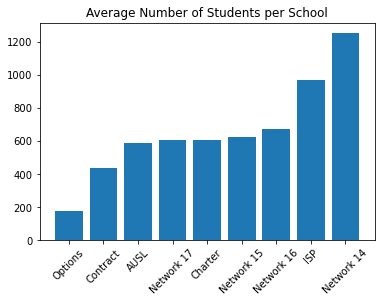

In [ ]:
fig, ax = plt.subplots()

y = sy_1819_hs.groupby('Network').mean()['Student_Count_Total'].sort_values().values
x = sy_1819_hs.groupby('Network').mean()['Student_Count_Total'].sort_values().index

ax.bar(x,y)
ax.set_xticklabels(x, rotation=45)
ax.set_title('Average Number of Students per School');

The Options network has significantly less number of average students.  

In [ ]:
sy_1819_hs.groupby('Network').sum()['Student_Count_Total']

Network
AUSL           2925
Charter       27408
Contract        868
ISP           16494
Network 14    20050
Network 15    11182
Network 16    12087
Network 17    10941
Options        5897
Name: Student_Count_Total, dtype: int64

# Next Steps:

Investigate Low Income Student Counts

Investigate exactly what the two Contract Schools are.

Make a student count attribute, both for total students and for high school students.